In [1]:
from functools import lru_cache
from random import random

import numpy as np
import torch
from tqdm import tqdm
from scipy import special, optimize, integrate
from scipy.stats import binom
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [42]:
TARGETED_DEGREE = 4.3


def _calc_p(k, n):
    # return (k + 0.5) / n
    return (TARGETED_DEGREE-1) / (n - 1)


def _pdf(x, alpha, lambd):
    '''
        pdf of variance gamma distribution
        with mu = beta = 0
        and according to https://en.wikipedia.org/wiki/Variance-gamma_distribution
    '''
    return ((alpha*alpha)**lambd * np.abs(x)**(lambd-0.5) * special.kv(lambd - 0.5, alpha*np.abs(x))) / \
        (np.sqrt(np.pi) * special.gamma(lambd) * (2*alpha)**(lambd - 0.5))


def _cdf(q, alpha, lambd):
    return integrate.quad(lambda x: _pdf(x, alpha, lambd), -np.inf, q)[0]


@lru_cache(maxsize=None)
def _icdf(q, alpha, lambd):
    # src: https://github.com/scipy/scipy/blob/main/scipy/stats/_distn_infrastructure.py#L1981
    factor = 10.
    left, right = -np.inf, np.inf

    if np.isinf(left):
        left = min(-factor, right)
        while _cdf(left, alpha, lambd)  - q > 0.:
            left, right = left * factor, left
        # left is now such that cdf(left) <= q
        # if right has changed, then cdf(right) > q

    if np.isinf(right):
        right = max(factor, left)
        while _cdf(right, alpha, lambd)  - q < 0.:
            left, right = right, right * factor
        # right is now such that cdf(right) >= q

    return optimize.brentq(lambda x: _cdf(x, alpha, lambd) - q, left, right)


def naive_decode(x):
    # assume x is a random node feature matrix
    adj = torch.matmul(x, x.t())

    return torch.sigmoid(adj)

def decode(x):
    # assume x is a random node feature matrix
    num_nodes = x.shape[0]
    assert x.shape[1] % 2 == 0
    hidden_channels = x.shape[1]

    adj = torch.matmul(x, x.t())
    
    targeted_p = 1 - _calc_p(TARGETED_DEGREE*num_nodes, num_nodes)
    correction_factor = _icdf(targeted_p, alpha=0.5, lambd=hidden_channels/2)/2
    adj -= correction_factor

    return torch.sigmoid(adj)


def average_degree_of_adj(adj):
    return torch.mean(torch.sum(adj, dim=1))


def random_degree_for_size(num_nodes, hidden_channels):
    x = torch.randn((num_nodes, hidden_channels), dtype=torch.float32)

    return average_degree_of_adj(decode(x)), average_degree_of_adj(naive_decode(x))

In [43]:

node_counts = []
degrees = []
naive_degrees = []
REPETITIONS = 30
prob = 1
for node_count in tqdm(range(6, 1000, 3)):
    prob *= 0.987
    for rep in range(REPETITIONS):
        if random() > prob:
            continue
        node_counts.append(node_count)
        corrected, naive = random_degree_for_size(node_count, 64)
        naive_degrees.append(naive)
        degrees.append(corrected)

100%|██████████| 332/332 [00:10<00:00, 30.28it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


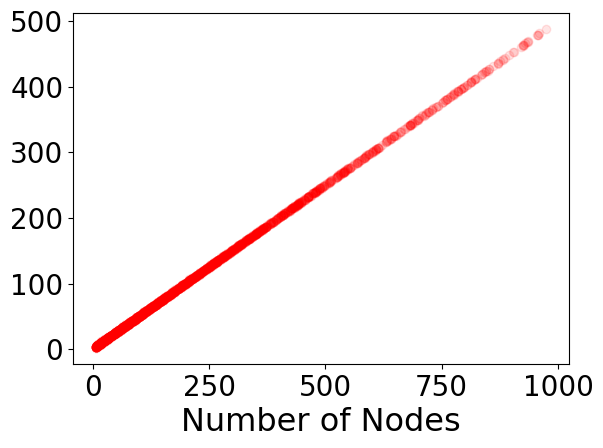

In [40]:
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.rc("axes", labelsize=23)
plt.xlabel("Number of Nodes")

plt.scatter(x=node_counts, y=naive_degrees, color="r", alpha=0.1)
plt.subplots_adjust(bottom=0.15)
plt.savefig("../results/random_deg.eps")
plt.savefig("../results/random_deg.pdf")
plt.savefig("../results/random_deg.png")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


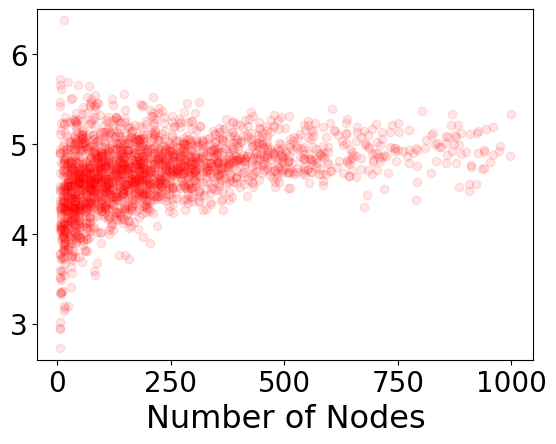

In [44]:
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.rc("axes", labelsize=23)
plt.xlabel("Number of Nodes")

plt.scatter(x=node_counts, y=degrees, color="r", alpha=0.1)
plt.ylim(2.6,6.5)
plt.subplots_adjust(bottom=0.15)
plt.savefig("../results/adjusted_deg.eps")
plt.savefig("../results/adjusted_deg.pdf")
plt.savefig("../results/adjusted_deg.png")

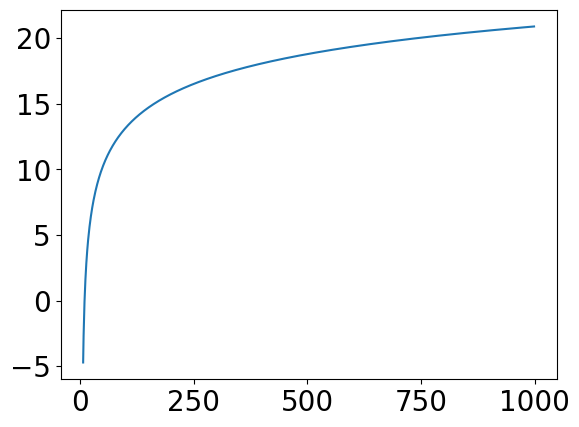

In [18]:
X = np.arange(7, 1000)
targeted_p = [1 - _calc_p(TARGETED_DEGREE*x, x*x) for x in X]
correction_factor = [_icdf(x, alpha=0.5, lambd=32)/2 for x in targeted_p]
plt.plot(X, correction_factor)

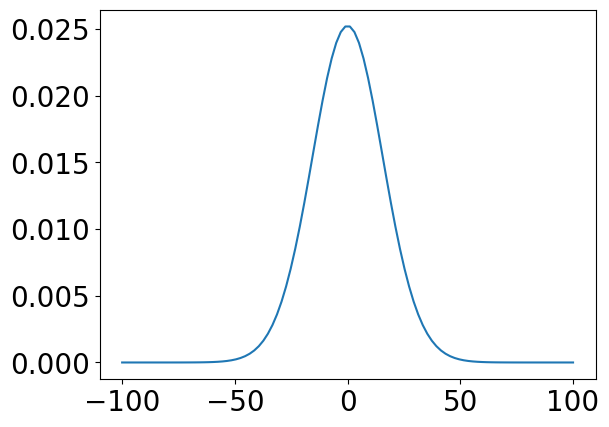

In [15]:
X = np.linspace(-100, 100, 100)
plt.plot(X, [_pdf(x, alpha=0.5, lambd=32) for x in X])

In [32]:
def _calc_p2(k, n):
    return optimize.brentq(lambda p: binom.cdf(k, n, p) - 0.5, 0, 1, xtol=1e-12)

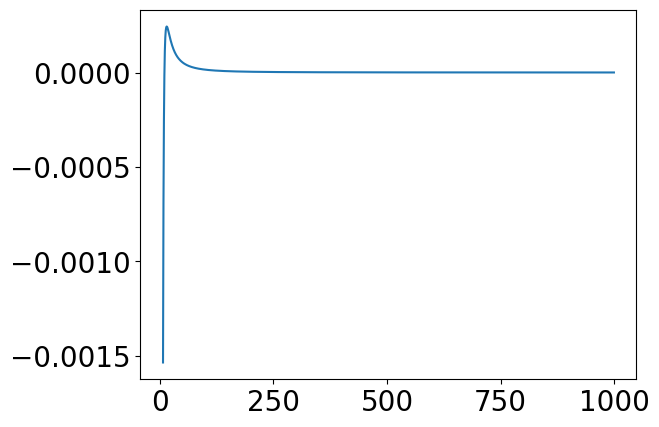

In [33]:
X = np.arange(7, 1000)
targeted_p = np.asarray([1 - _calc_p(TARGETED_DEGREE*x, x*x) for x in X])
targeted_p2 = np.asarray([1 - _calc_p2(TARGETED_DEGREE*x, x*x) for x in X])

plt.plot(X, targeted_p - targeted_p2)